# Getting started with TensorFlow on Arduino

[#TinyML](https://twitter.com/hashtag/tinyML) has grown popularity in the past couple years thanks to a few big players who entered the fields: the giant in the arean is TensorFlow.

Thanks to [TensorFlow for Microcontrollers](https://www.tensorflow.org/lite/microcontrollers) you can train a neural network in Python and run it on your microcontroller of choice.

The official documentation lacks ease of use for a novice, so here's a short article on how to train, export and run your first neural network in the Arduino ecosystem.

## Predict sine(x)

Many books on TinyML start with a *toy* example of how to predict the sine of a value using a neural network. This is something you will never do in the real world, but it is simple enough to let you focus more on the development process than on the actual use.

**This article assumes you have already have a basic knowledge on how to create and train a neural network with TensorFlow in Python. If this is not the case, please read a couple tutorials before.**

In [24]:
! pip install tensorflow

You should consider upgrading via the '/Users/simone/PycharmProjects/ebooks/Getting started with TinyML on Arduino/venv/bin/python -m pip install --upgrade pip' command.


In [7]:
"""
Create a toy model to predict sine(x)
"""
import math
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers


def get_model(num_samples=1000, **kwargs):
    np.random.seed(1337)
    X = np.random.uniform(low=0, high=2 * math.pi, size=num_samples)
    
    # shuffle and add noise
    np.random.shuffle(X)
    Y = np.sin(X) + 0.1 * np.random.randn(len(X))

    # split into train, validation, test
    TRAIN_SPLIT =  int(0.6 * num_samples)
    TEST_SPLIT = int(0.2 * num_samples + TRAIN_SPLIT)
    X_train, X_test, X_validate = np.split(X, [TRAIN_SPLIT, TEST_SPLIT])
    y_train, y_test, y_validate = np.split(X, [TRAIN_SPLIT, TEST_SPLIT])

    # create a neural network with 2 layers of 16 neurons and a single output
    model = tf.keras.Sequential()
    model.add(layers.Dense(16, activation='relu', input_shape=(1,)))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    model.fit(X_train, y_train, epochs=200, batch_size=16, validation_data=(X_validate, y_validate), **kwargs)
    
    return model, X_test, y_test

In [25]:
"""
Instantiate a model and test accuracy
"""
model, X_test, y_test = get_model(verbose=0)
y_pred = model.predict(X_test, verbose=0)

Before moving on, let's check that our model is able to correctly predict the sine function.

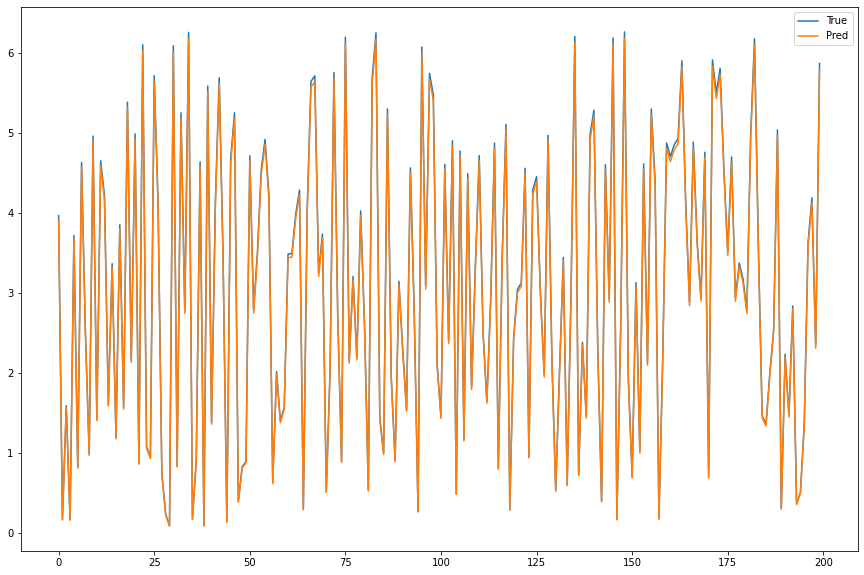

In [15]:
"""
Plot true values and predicted values
"""
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
plt.plot(np.arange(len(X_test)), y_test.flatten(), label='True')
plt.plot(np.arange(len(X_test)), y_pred.flatten(), label='Pred')
plt.legend()

Fine, it looks like the network did a good job.

Now we want to run this same network on our Arduino board. It is pretty easy to do so thanks to a couple libraries:

 - [tinymlgen](https://eloquentarduino.com/libraries/tinymlgen) Python library: converts a TensorFlow network to C++ code
 - [EloquentTinyML](https://eloquentarduino.com/libraries/eloquent-tinyml) Arduino library: runs an exported TensorFlow network

### Export TensorFlow network to C++

In [26]:
! pip install tinymlgen

You should consider upgrading via the '/Users/simone/PycharmProjects/ebooks/Getting started with TinyML on Arduino/venv/bin/python -m pip install --upgrade pip' command.


In [27]:
"""
Convert model to C++ for Arduino
"""
from tinymlgen import port

c_code = port(model, pretty_print=True, optimize=[tf.lite.Optimize.DEFAULT])

INFO:tensorflow:Assets written to: /var/folders/dj/krrkt8p95qndhg46m2n774d80000gn/T/tmpwkjzdm8k/assets


INFO:tensorflow:Assets written to: /var/folders/dj/krrkt8p95qndhg46m2n774d80000gn/T/tmpwkjzdm8k/assets
2022-05-17 09:19:02.750722: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-05-17 09:19:02.750769: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-05-17 09:19:02.754320: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/dj/krrkt8p95qndhg46m2n774d80000gn/T/tmpwkjzdm8k
2022-05-17 09:19:02.760959: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2022-05-17 09:19:02.761000: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: /var/folders/dj/krrkt8p95qndhg46m2n774d80000gn/T/tmpwkjzdm8k
2022-05-17 09:19:02.773574: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-05-17 09:19:02.864377: I tensorflow/cc/saved_model/loader.cc:212] Running initialization

In [30]:
"""
Save model to C header file
"""
with open('sine_model.h', 'w') as file:
    file.write(c_code)

In [31]:
! cat sine_model.h


#ifdef __has_attribute
#define HAVE_ATTRIBUTE(x) __has_attribute(x)
#else
#define HAVE_ATTRIBUTE(x) 0
#endif
#if HAVE_ATTRIBUTE(aligned) || (defined(__GNUC__) && !defined(__clang__))
#define DATA_ALIGN_ATTRIBUTE __attribute__((aligned(4)))
#else
#define DATA_ALIGN_ATTRIBUTE
#endif

const unsigned char model_data[] DATA_ALIGN_ATTRIBUTE = {
	0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00, 
	0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00, 0x0c, 0x00, 0x00, 0x00, 
	0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 
	0x94, 0x00, 0x00, 0x00, 0xec, 0x00, 0x00, 0x00, 0x08, 0x07, 0x00, 0x00, 
	0x18, 0x07, 0x00, 0x00, 0xf4, 0x0b, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00, 
	0x01, 0x00, 0x00, 0x00, 0x10, 0x00, 0x00, 0x00, 0x00, 0x00, 0x0a, 0x00, 
	0x10, 0x00, 0x0c, 0x00, 0x08, 0x00, 0x04, 0x00, 0x0a, 0x00, 0x00, 0x00, 
	0x0c, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x38, 0x00, 0x00, 0x00, 
	0x0f, 0x00, 0x00, 0x00, 0x73, 0x65, 0x72, 0x76, 0x69, 0x6e, 0x67,

### Run TensorFlow network on Arduino

```cpp
#include <EloquentTinyML.h>
#include <eloquent_tinyml/tensorflow.h>

// sine_model.h contains the array you exported from Python
#include "sine_model.h"

#define N_INPUTS 1
#define N_OUTPUTS 1
// in future projects you may need to tweak this value: it's a trial and error process
#define TENSOR_ARENA_SIZE 2*1024

Eloquent::TinyML::TensorFlow::TensorFlow<N_INPUTS, N_OUTPUTS, TENSOR_ARENA_SIZE> tf;


void setup() {
    Serial.begin(115200);
    delay(4000);
    tf.begin(sine_model);

    // check if model loaded fine
    if (!tf.isOk()) {
      Serial.print("ERROR: ");
      Serial.println(tf.getErrorMessage());

      while (true) delay(1000);
    }
    
    Serial.println("Model OK");
}

void loop() {
    for (float i = 0; i < 10; i++) {
        // pick x from 0 to PI
        float x = 3.14 * i / 10;
        float y = sin(x);
        float input[1] = { x };
        float predicted = tf.predict(input);

        Serial.print("sin(");
        Serial.print(x);
        Serial.print(") = ");
        Serial.print(y);
        Serial.print("\t predicted: ");
        Serial.println(predicted);
    }

    delay(1000);
}
```